🎙 Grabando desde el micrófono por máximo 30 s...
✔ Grabación finalizada.


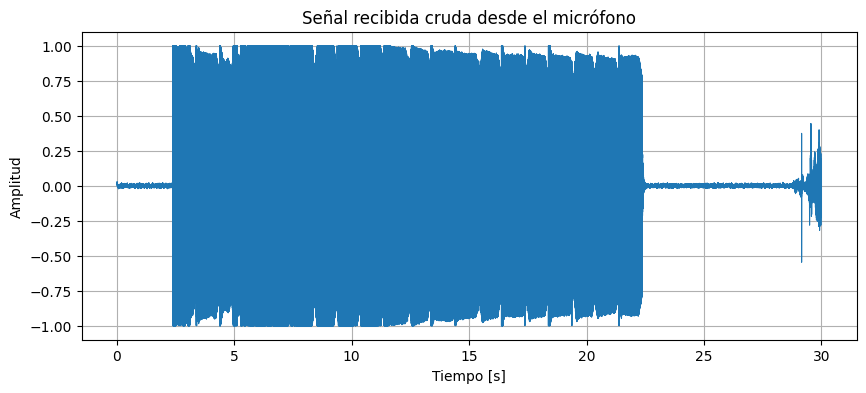

🔍 Buscando trama de inicio...
   Inicio detectado en muestra 69285 (corr=57.3257)
🔍 Buscando trama de fin...


In [ ]:
import numpy as np
START_BITS = "000001011110101100111000"   # preámbulo de inicio
END_BITS   = "111110000111110000111"      # trama final

def pll_track_phase(signal, fs, fc, Kp=0.01, Ki=0.001):
    """
    PLL muy simple para estimar la fase de una portadora conocida fc.
    Devuelve:
      - phase_hist: evolución de la fase estimada por muestra
      - phase_final: fase final estimada
    """

    N = len(signal)
    phase = 0.0         # fase inicial
    integ = 0.0         # término integral
    phase_hist = np.zeros(N)
    w0 = 2 * np.pi * fc / fs  # frecuencia normalizada

    for n in range(N):
        # oscilador local
        lo = np.cos(w0 * n + phase)

        # detector de fase simple: error ~ producto señal * lo
        error = signal[n] * lo

        # lazo PI
        integ += Ki * error
        phase += Kp * error + integ

        phase_hist[n] = phase

    phase_final = phase_hist[-1]
    return phase_hist, phase_final

import sounddevice as sd
import matplotlib.pyplot as plt
def raised_cosine_pulse(Tb, fs, beta=0.25):
    N = int(Tb * fs)
    t = np.linspace(-Tb/2, Tb/2, N)

    h = np.zeros(N)
    for i, ti in enumerate(t):
        if ti == 0:
            h[i] = 1.0
        elif abs(1 - (2 * beta * ti/Tb)**2) < 1e-8:
            h[i] = (np.pi/4) * np.sinc(1/(2*beta))
        else:
            h[i] = (np.sin(np.pi * ti / Tb) / (np.pi * ti / Tb)) * \
                   (np.cos(np.pi * beta * ti / Tb) /
                    (1 - (2 * beta * ti / Tb)**2))

    return h, N
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt

def record_and_receive_8qam(
    Tb=0.005,
    fs=48000,
    fc=12000,
    beta=0.25,
    max_duration=10.0
):

    print(f"🎙 Grabando desde el micrófono por máximo {max_duration} s...")
    num_samples = int(max_duration * fs)
    recording = sd.rec(num_samples, samplerate=fs, channels=1, dtype='float32')
    sd.wait()
    print("✔ Grabación finalizada.")

    # Señal cruda tal cual la entregó el micrófono
    rx = recording[:, 0]

    # ===== 0. GRAFICAR SEÑAL CRUDA =====
    t_full = np.arange(len(rx)) / fs

    plt.figure(figsize=(10,4))
    plt.plot(t_full, rx, linewidth=0.8)
    plt.title("Señal recibida cruda desde el micrófono")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.grid(True)
    plt.show()

    # ===== 1. Generar las tramas localmente =====
    t_start, s_start, _, _ = modulate_8qam(START_BITS, Tb, fs, fc, beta)
    t_end,   s_end,   _, _ = modulate_8qam(END_BITS,   Tb, fs, fc, beta)

    s_start = s_start / np.max(np.abs(s_start))
    s_end   = s_end   / np.max(np.abs(s_end))
    rx_norm = rx / (np.max(np.abs(rx)) + 1e-12)

    # ===== 2. Buscar inicio =====
    print("🔍 Buscando trama de inicio...")
    corr_start = np.correlate(rx_norm, s_start, mode='valid')
    idx_start = np.argmax(corr_start)
    peak_start = corr_start[idx_start]
    print(f"   Inicio detectado en muestra {idx_start} (corr={peak_start:.4f})")
    # Dectado en el segundo
    print(f"   Inicio detectado en tiempo {idx_start/fs:.3f} s")

    start_sample = idx_start

    # ===== 3. Buscar fin =====
    print("🔍 Buscando trama de fin...")
    search_region = rx_norm[start_sample + len(s_start):]

    if len(search_region) < len(s_end):
        raise RuntimeError("Grabación demasiado corta para contener START + END.")

    corr_end = np.correlate(search_region, s_end, mode='valid')
    idx_end_rel = np.argmax(corr_end)
    peak_end = corr_end[idx_end_rel]
    end_sample = start_sample + len(s_start) + idx_end_rel

    print(f"   Fin detectado en muestra {end_sample} (corr={peak_end:.4f})")
    print(f"   Fin detectado en tiempo {end_sample/fs:.3f} s")

    # ===== 4. Recortar =====
    msg_signal = rx[start_sample:end_sample + len(s_end)]
    t_msg = np.arange(len(msg_signal)) / fs

    print(f"📦 Mensaje recortado: {len(msg_signal)} muestras -> {len(msg_signal)/fs:.3f} s")

    # ===== 5. PLL =====
    phase_hist, phase_final = pll_track_phase(msg_signal, fs, fc)
    print(f"📐 Fase final estimada: {phase_final:.4f} rad")

    # ===== 6. Graficar señal recortada + fase =====
    plt.figure(figsize=(10,6))

    plt.subplot(2,1,1)
    plt.plot(t_msg, msg_signal, linewidth=0.8)
    plt.title("Señal recortada entre START y END")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Amplitud")
    plt.grid(True)

    plt.subplot(2,1,2)
    plt.plot(t_msg, phase_hist)
    plt.title("Evolución de la fase del PLL")
    plt.xlabel("Tiempo [s]")
    plt.ylabel("Fase [rad]")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return t_full, rx, t_msg, msg_signal, phase_hist, phase_final
def modulate_8qam(bits, Tb, fs, fc, beta=0.25):
    """
    Modula una cadena de bits usando 8QAM + Raised Cosine.

    bits : str       Cadena de bits (long múltiplo de 3)
    Tb   : float     Duración de símbolo (NO de bit)
    fs   : float     Frecuencia de muestreo
    fc   : float     Frecuencia de portadora
    beta : float     Roll-off
    """

    # Verificación
    if len(bits) % 3 != 0:
        raise ValueError("La cantidad de bits debe ser múltiplo de 3 para 8QAM.")

    # --- Mapeo Gray 3 bits → (I,Q) ---
    mapping = {
        "000": (-1, -1),
        "001": (-1,  0),
        "011": (-1, +1),
        "010": ( 0, +1),
        "110": (+1, +1),
        "111": (+1,  0),
        "101": (+1, -1),
        "100": ( 0, -1),
    }

    symbols = [bits[i:i+3] for i in range(0, len(bits), 3)]
    IQ = np.array([mapping[s] for s in symbols])

    # --- Pulso Raised Cosine ---
    h, N = raised_cosine_pulse(Tb, fs, beta)

    total_samples = len(symbols) * N
    t = np.linspace(0, Tb * len(symbols), total_samples, endpoint=False)

    # Señales banda base I(t) y Q(t)
    I = np.zeros(total_samples)
    Q = np.zeros(total_samples)

    for k, (I0, Q0) in enumerate(IQ):
        start = k * N
        end = start + N
        I[start:end] += I0 * h
        Q[start:end] += Q0 * h

    # --- Modulación en frecuencia ---
    carrier_cos = np.cos(2 * np.pi * fc * t)
    carrier_sin = np.sin(2 * np.pi * fc * t)

    # Señal 8QAM pasabanda
    s = I * carrier_cos - Q * carrier_sin

    return t, s, I, Q

# Parámetros (deben coincidir con el transmisor)
t_full, rx, t_msg, msg_signal, phase_hist, phase_final = record_and_receive_8qam(
    Tb=1,
    fs=48000,
    fc=12000,
    beta=0.25,
    max_duration=30
)

